In [1]:
# This simulates Phasecam pupil images
# (original purpose: drawing a cartoon)

# The most important thing to calculate here is the tilt between the two beams at K and H

# created 2019 Mar 15 by E.S.

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy import ndimage
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
import matplotlib.cm as cmx

%matplotlib inline
#%matplotlib qt

In [2]:
lmir_PS = 0.0107 # LMIR plate scale (asec per pixel)
pc_PS = 0.078 # PC plate scale (asec per pixel; Defrere+ 2015)
lambda_K = 2.2e-6 # wavelength of Phasecam (m)
lambda_H = 1.6e-6 # wavelength of Phasecam (m)
c = 3e8 # speed of light (m/s)

In [3]:
# calculate angle due to dispersion

In [4]:
# dispersion relation for ZnSe (Connolly et al. 1979: n 0.54-18.2 µm)
# (as posted on https://refractiveindex.info/?shelf=main&book=ZnSe&page=Connolly)

def n_znse(lambda_um):
    '''
    Index of refraction for Ge
    
    INPUT:
    wavelength (um)
    
    OUTPUT:
    index of ref n
    '''
    
    # read in csv and find n at nearest wavelength
    n_znse_list = pd.read_csv("data/n_znse.csv")
    
    # interpolate
    n = np.interp(lambda_um, n_znse_list["wavel_um"], n_znse_list["n"])
    
    return n

In [5]:
# dispersion relation for Ge (Li 1980: n 1.9-18 µm; 100 K)
# (as posted on https://refractiveindex.info/?shelf=main&book=Ge&page=Li-100K)

def n_ge(lambda_um):
    '''
    Index of refraction for Ge
    
    INPUT:
    wavelength (um)
    
    OUTPUT:
    index of ref n
    '''
    
    # read in csv and find n at nearest wavelength
    n_ge_list = pd.read_csv("data/n_ge.csv")
    
    # interpolate
    n = np.interp(lambda_um, n_ge_list["wavel_um"], n_ge_list["n"])
    
    return n

In [6]:
def snell_theta_t(ni, nt, theta_i):
    '''
    Finds the transmitted angle via Snell's law
    
    INPUTS:
    ni: index of refraction of incident material (ASSUMED CONSTANT HERE)
    nt: index of refraction of transmission material
    theta_i: incident angle (in deg)
    '''
    
    sin_theta_t = np.divide(ni,nt)*np.sin(theta_i*np.pi/180.)
    theta_t = np.arcsin(sin_theta_t)*180./np.pi
    
    return theta_t

In [7]:
# see Buscher+ 2015, sec. 1.4

def illum_PC(lambda_PC, beta_PC, tao12_PC, x_coord_pre_rot, deg_rot=0):
    '''
    Generate a pupil image of fringes
    
    INPUTS:
    lambda_PC: wavelength of Phasecam (m)
    beta_PC: angle of converging beams (deg)
    tao12_PC: phase shift (deg)
    x_coord_pre_rot: x pixel coordinate of image, before any rotation
    deg_rot: degrees to rotate CW
    '''
    
    # argument of the exp part
    arg_exp = np.divide(2*np.pi*1j,lambda_PC)*(2*np.divide(pc_PS*x_coord_pre_rot,206265)*\
                                               np.sin(beta_PC*np.pi/180.) + c*tao12_PC*np.pi/180.)
    
    # illumination before any rotation
    i_x_pre_rot = 1 + np.real(np.exp(arg_exp))
    
    # apply rotation (+ -> CW)
    if (deg_rot != 0):
        i_x_post_rot = scipy.ndimage.rotate(i_x_pre_rot, angle=deg_rot)
        return i_x_post_rot
    else:
        return i_x_pre_rot

In [2]:
# circular mask

def create_circular_mask(image, center=None, radius=None):

    h, w = np.shape(image)
    
    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [9]:
# initialize a grid

x = np.arange(0, 100)
y = np.arange(0, 100)
xv, yv = np.meshgrid(x, y)

In [134]:
pc_image_K = illum_PC(lambda_PC=lambda_K, 
                beta_PC=10, 
                tao12_PC=5, 
                x_coord_pre_rot=xv,
                deg_rot=0)
mask_circle = create_circular_mask(pc_image_K, radius = 30)
pc_image_K = np.multiply(pc_image_K,mask_circle)

In [135]:
white_mask = np.copy(mask_circle.astype(int))
white_mask = (1-white_mask)
white_mask[white_mask == 1] = 2

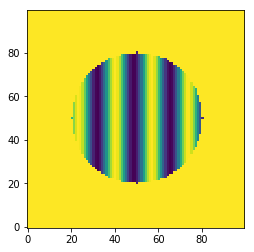

In [136]:
test = np.add(pc_image_K,white_mask)
plt.imshow(test, origin="lower")
#plt.colorbar()
plt.show()

In [137]:
# write FITS

hdu = fits.PrimaryHDU(test)
hdul = fits.HDUList([hdu])
hdul.writeto('junk.fits', overwrite=True)

In [138]:
class fft_img:
    # take FFT of a 2D image

    def __init__(self, image):
        self.image = image

    def fft(self, padding=int(0), pad_mode='constant', mask_thresh=1e-10, mask=True):

        padI = np.pad(self.image, padding, pad_mode)
        # arguments: image, pad size, pad mode, threshold for masking, mask flag
        padI = np.fft.fftshift(padI)
        PhaseExtract = np.fft.fft2(padI)
        PhaseExtract = np.fft.fftshift(PhaseExtract)
        AmpPE = np.absolute(PhaseExtract)
        #ArgPE = np.multiply(np.angle(PhaseExtract),180./np.pi) # degrees
        ArgPE = np.angle(PhaseExtract) # radians

        print("Size of array being FFTed:")
        print(np.shape(PhaseExtract))

        if mask:
            # mask out low-power regions
            AmpPE_masked = ma.masked_where(AmpPE < mask_thresh, AmpPE, copy=False)
            ArgPE_masked = ma.masked_where(AmpPE < mask_thresh, ArgPE, copy=False)
            return AmpPE_masked, ArgPE_masked

        else:
            return AmpPE, ArgPE

In [139]:
amp, arg = fft_img(pc_image_K).fft(padding = 500)

Size of array being FFTed:
(1100, 1100)


In [140]:
# remove central lobe
N = 33
amp[:,int(0.5*np.shape(amp)[1]-N):-2*N] = amp[:,int(0.5*np.shape(amp)[1]+N):]
arg[:,int(0.5*np.shape(arg)[1]-N):-2*N] = arg[:,int(0.5*np.shape(arg)[1]+N):]

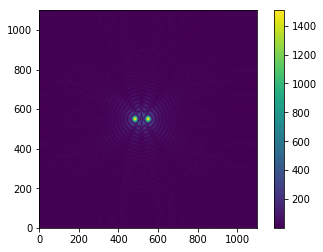

In [141]:
plt.imshow(amp, origin="lower")#, norm=LogNorm(vmin=0.01, vmax=1000))
plt.colorbar()
plt.show()

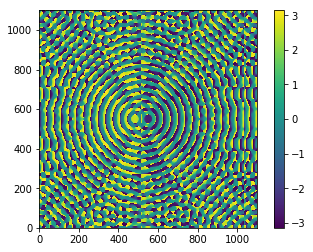

In [142]:
plt.imshow(arg, origin="lower")#, norm=LogNorm(vmin=0.01, vmax=1000))
plt.colorbar()
plt.show()

In [144]:
# write FITS

hdu = fits.PrimaryHDU(amp.data)
hdul = fits.HDUList([hdu])
hdul.writeto('junk.fits', overwrite=True)

In [11]:
pc_image_H = illum_PC(lambda_PC=lambda_H, 
                beta_PC=45, 
                tao12_PC=0, 
                x_coord_pre_rot=xv,
                deg_rot=10)
mask_circle = create_circular_mask(pc_image_H, radius = 25)
pc_image_H = np.multiply(pc_image_H,mask_circle)

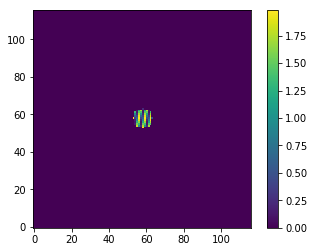

In [14]:
plt.imshow(pc_image_H, origin="lower")
plt.colorbar()
plt.show()

In [16]:
# write FITS

hdu = fits.PrimaryHDU(pc_image_H)
hdul = fits.HDUList([hdu])
hdul.writeto('junk_H.fits', overwrite=True)

In [3]:
dummy_frame = np.ones((100,100))

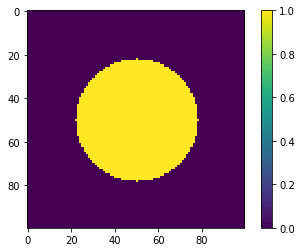

In [17]:
## INTERMISSION: MAKING A MASK FOR PCA DECOMPOSITION OF PSFS IN ALTAIR PROJECT

# initialize a grid
x = np.arange(0, 100)
y = np.arange(0, 100)
xv, yv = np.meshgrid(x, y)

mask_circle = create_circular_mask(dummy_frame, radius = 28)

# turn to integers
plt.imshow(mask_circle.astype(int))
plt.colorbar()
plt.show()

# write FITS
hdu = fits.PrimaryHDU(mask_circle.astype(int))
hdul = fits.HDUList([hdu])
hdul.writeto('mask_100x100_rad028.fits', overwrite=True)

In [93]:
## INTERMISSION: MAKING A MASK FOR PCA DECOMPOSITION OF PSFS IN ALTAIR PROJECT

# initialize a grid
x = np.arange(0, 100)
y = np.arange(0, 100)
xv, yv = np.meshgrid(x, y)

mask_circle = create_circular_mask(dummy_frame, radius = 28)

# turn to integers
plt.imshow(mask_circle.astype(int), origin="lower")
plt.colorbar()
plt.show()

# write FITS
hdu = fits.PrimaryHDU(mask_circle.astype(int))
hdul = fits.HDUList([hdu])
#hdul.writeto('mask_100x100_rad028.fits', overwrite=True)

NameError: name 'create_circular_mask' is not defined

In [2]:
slices = 4
this_cube = np.zeros((slices,100,100))

for square_num in range(0, slices):
    '''
    Make a square for each slice
    '''
    
    this_slice = np.zeros((100,100))
    this_slice[50:,50:] = 1
    this_cube[square_num,:,:] = this_slice

    plt.imshow(dummy_frame)
    plt.show()

NameError: name 'dummy_frame' is not defined

In [31]:
def get_cmap(N):
    ''' Returns a function that maps each index in 0, 1, ...
        N-1 to a distinct RGB color.'''
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='hsv')
    #scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='gist_stern')
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

In [36]:
from collections import OrderedDict
cmaps = OrderedDict()

cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

In [35]:
# quad4 mask definition
slices = 4
this_cube = np.zeros((slices,100,100))

this_slice = np.zeros((100,100))
this_slice[50:,50:] = 1
this_cube[0,:,:] = this_slice

this_slice = np.zeros((100,100))
this_slice[50:,:50] = 1
this_cube[1,:,:] = this_slice

this_slice = np.zeros((100,100))
this_slice[:50,:50] = 1
this_cube[2,:,:] = this_slice

this_slice = np.zeros((100,100))
this_slice[:50,50:] = 1
this_cube[3,:,:] = this_slice

#hdu = fits.PrimaryHDU(this_cube.astype(int))
#hdul = fits.HDUList([hdu])
#hdul.writeto('mask_100x100_4quad.fits', overwrite=True)

OrderedDict()

In [88]:
# 100 squares mask definition
slices = 100
this_cube = np.zeros((slices,100,100))

slice_num = 0

# y
for i in range(0,10):
    # x
    for j in range(0,10):
        this_slice = np.zeros((100,100))
        this_slice[10*i:10*(i+1),10*j:10*(j+1)] = 1
        this_cube[slice_num,:,:] = this_slice
        slice_num += 1

hdu = fits.PrimaryHDU(this_cube.astype(int))
hdul = fits.HDUList([hdu])
hdul.writeto('mask_10x10_100squares.fits', overwrite=True)

In [7]:
# simple whole-frame 100x100 mask definition

# note this has two redundant slices, because otherwise the dimensions get messed up
this_slice = np.ones((2,100,100))

hdu = fits.PrimaryHDU(this_slice.astype(int))
hdul = fits.HDUList([hdu])
hdul.writeto('mask_100x100pix_whole_frame.fits', overwrite=True)

In [102]:
# quad4_circ mask definition
# 1= good; 0= bad

slices = 8
this_cube = np.zeros((slices,100,100))
dummy_frame = np.ones((100,100))

# define quadrants across slices first
this_slice = np.zeros((100,100))
this_slice[50:,50:] = 1
this_cube[0,:,:] = this_slice
this_cube[4,:,:] = this_slice

this_slice = np.zeros((100,100))
this_slice[50:,:50] = 1
this_cube[1,:,:] = this_slice
this_cube[5,:,:] = this_slice

this_slice = np.zeros((100,100))
this_slice[:50,:50] = 1
this_cube[2,:,:] = this_slice
this_cube[6,:,:] = this_slice

this_slice = np.zeros((100,100))
this_slice[:50,50:] = 1
this_cube[3,:,:] = this_slice
this_cube[7,:,:] = this_slice

# now, multiply the first set of slices by a circular mask
mask_circle = create_circular_mask(dummy_frame, radius = 22)
this_cube[0:4,:,:] = np.multiply(this_cube[0:4,:,:],mask_circle)

# and multiply the second set of slices by the inverse circular mask
this_cube[4:,:,:] = np.multiply(this_cube[4:,:,:],np.abs(np.subtract(mask_circle,1)))

# write out
hdu = fits.PrimaryHDU(this_cube.astype(int))
hdul = fits.HDUList([hdu])
hdul.writeto('mask_quad4_circ.fits', overwrite=True)

In [102]:
# quad4_circ mask definition
# 1= good; 0= bad

slices = 8
this_cube = np.zeros((slices,100,100))
dummy_frame = np.ones((100,100))

# define quadrants across slices first
this_slice = np.zeros((100,100))
this_slice[50:,50:] = 1
this_cube[0,:,:] = this_slice
this_cube[4,:,:] = this_slice

this_slice = np.zeros((100,100))
this_slice[50:,:50] = 1
this_cube[1,:,:] = this_slice
this_cube[5,:,:] = this_slice

this_slice = np.zeros((100,100))
this_slice[:50,:50] = 1
this_cube[2,:,:] = this_slice
this_cube[6,:,:] = this_slice

this_slice = np.zeros((100,100))
this_slice[:50,50:] = 1
this_cube[3,:,:] = this_slice
this_cube[7,:,:] = this_slice

# now, multiply the first set of slices by a circular mask
mask_circle = create_circular_mask(dummy_frame, radius = 22)
this_cube[0:4,:,:] = np.multiply(this_cube[0:4,:,:],mask_circle)

# and multiply the second set of slices by the inverse circular mask
this_cube[4:,:,:] = np.multiply(this_cube[4:,:,:],np.abs(np.subtract(mask_circle,1)))

# write out
hdu = fits.PrimaryHDU(this_cube.astype(int))
hdul = fits.HDUList([hdu])
hdul.writeto('mask_quad4_circ.fits', overwrite=True)

In [122]:
# quad4_circ_ring mask definition
# 1= good; 0= bad

slices = 12
this_cube = np.zeros((slices,100,100))
dummy_frame = np.ones((100,100))

# define quadrants across slices first
this_slice = np.zeros((100,100))
this_slice[50:,50:] = 1
this_cube[0,:,:] = this_slice
this_cube[4,:,:] = this_slice
this_cube[8,:,:] = this_slice

this_slice = np.zeros((100,100))
this_slice[50:,:50] = 1
this_cube[1,:,:] = this_slice
this_cube[5,:,:] = this_slice
this_cube[9,:,:] = this_slice

this_slice = np.zeros((100,100))
this_slice[:50,:50] = 1
this_cube[2,:,:] = this_slice
this_cube[6,:,:] = this_slice
this_cube[10,:,:] = this_slice

this_slice = np.zeros((100,100))
this_slice[:50,50:] = 1
this_cube[3,:,:] = this_slice
this_cube[7,:,:] = this_slice
this_cube[11,:,:] = this_slice

# now, multiply the first set of slices by a circular mask
mask_circle_inner = create_circular_mask(dummy_frame, radius = 12)
mask_circle_outer = create_circular_mask(dummy_frame, radius = 30)
this_cube[0:4,:,:] = np.multiply(this_cube[0:4,:,:],mask_circle_inner)

# and multiply the third set of slices by the outer circular mask and subtract the first
this_cube[8:12,:,:] = np.multiply(this_cube[8:12,:,:],np.abs(np.subtract(mask_circle_outer,1)))

# and multiply the second set of slices by the outer circular mask and subtract the first
dummy_slices = np.subtract(this_cube[4:8,:,:],this_cube[0:4,:,:])
this_cube[4:8,:,:] = np.subtract(dummy_slices,this_cube[8:12,:,:])


# write out
'''
hdu = fits.PrimaryHDU(this_cube.astype(int))
hdul = fits.HDUList([hdu])
hdul.writeto('mask_quad4_circ_ring.fits', overwrite=True)
'''

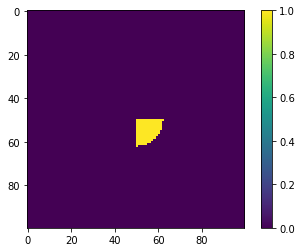

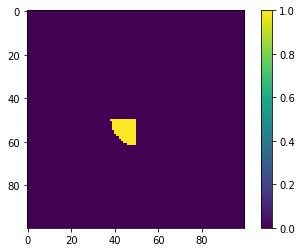

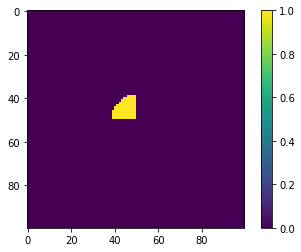

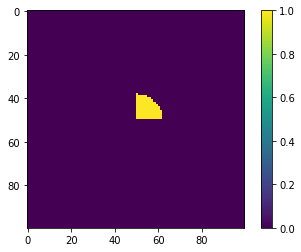

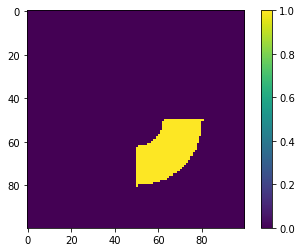

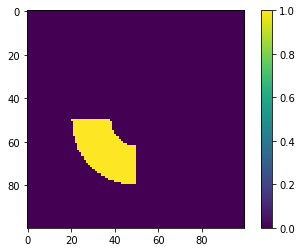

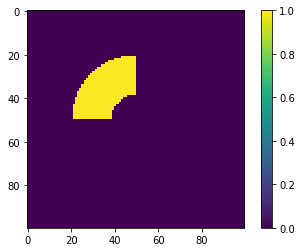

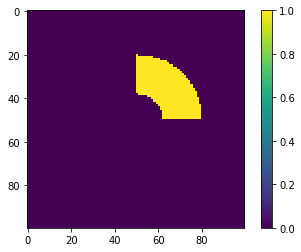

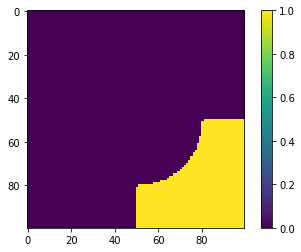

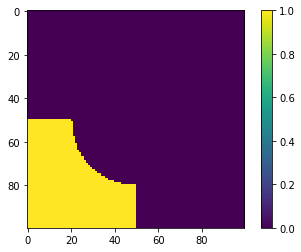

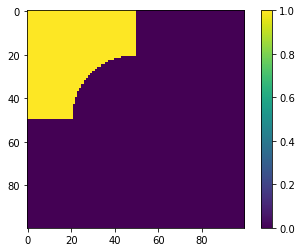

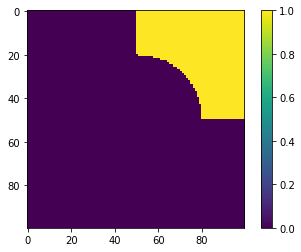

In [121]:
for t in range(0,len(this_cube)):
    plt.imshow(this_cube[t,:,:])
    plt.colorbar()
    plt.show()

In [80]:
summed_masks

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

These numbers should both be 1:
1.0
1.0
And here's a plot:


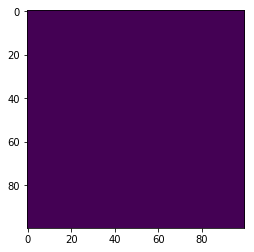

In [123]:
# test to make sure there is no region overlap, or places outside all regions

summed_masks = np.nansum(this_cube, axis=0)

print("These numbers should both be 1:")
print(np.min(summed_masks))
print(np.max(summed_masks))

print("And here's a plot:")
plt.imshow(summed_masks)
plt.show()

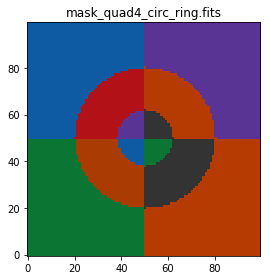

In [127]:
import matplotlib

for plot_num in range(0,slices):
    this_plot = this_cube[plot_num,:,:]
    this_plot[this_plot == 0] = np.nan # this to a
    plt.imshow(this_plot,
               cmap = cmaps['Sequential'][np.mod(plot_num,7)], 
               alpha = 1, vmin=0, vmax=1.2,
               origin = "lower")#np.random.random())
    #plt.colorbar() # for some reason, colorbar necessary to render plot
plt.title("mask_quad4_circ_ring.fits")
plt.tight_layout()
#plt.show()
plt.savefig("junk1.pdf")

In [72]:
np.random.rand ( 256,3 )

array([[0.03573456, 0.36534507, 0.51429586],
       [0.22368914, 0.86548429, 0.38722394],
       [0.19933871, 0.56376804, 0.87135822],
       [0.27269308, 0.45171641, 0.94777346],
       [0.23521262, 0.5035877 , 0.43786277],
       [0.61513183, 0.20428776, 0.48507197],
       [0.64194962, 0.82741179, 0.73755905],
       [0.1554633 , 0.36357552, 0.22002221],
       [0.05161331, 0.85374885, 0.11995131],
       [0.32060443, 0.27392182, 0.26636228],
       [0.42682176, 0.54278874, 0.86369326],
       [0.81384834, 0.85621987, 0.63581969],
       [0.97531128, 0.2170669 , 0.91975712],
       [0.66847182, 0.48601673, 0.83409362],
       [0.65171875, 0.84345565, 0.64091651],
       [0.80879954, 0.10931423, 0.48318514],
       [0.07826945, 0.66604476, 0.51187379],
       [0.71988005, 0.10018677, 0.66868719],
       [0.07880789, 0.95316861, 0.63216957],
       [0.46495215, 0.01843868, 0.21584136],
       [0.2411422 , 0.56143213, 0.0368234 ],
       [0.39822507, 0.92756762, 0.15858262],
       [0.

In [20]:
# make 'ring' masks 

sciImg1, header = fits.getdata("mask_100x100_rad028.fits",0,header=True)
sciImg2, header = fits.getdata("mask_100x100_rad021.fits",0,header=True)
sciImg3, header = fits.getdata("mask_100x100_rad011.fits",0,header=True)

In [28]:
ring_21_to_28 = np.subtract(sciImg1,sciImg2)
ring_11_to_21 = np.subtract(sciImg2,sciImg3)
rad_gtr_28 = np.subtract(np.ones(np.shape(sciImg1)),sciImg1)

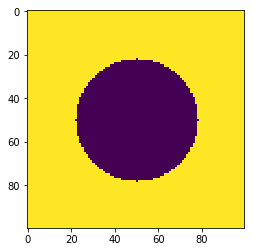

In [29]:
plt.imshow(rad_gtr_28)
plt.show()

In [26]:
hdu = fits.PrimaryHDU(ring_11_to_21)
hdul = fits.HDUList([hdu])
hdul.writeto('mask_100x100_ring_11_to_21.fits', overwrite=True)

In [27]:
hdu = fits.PrimaryHDU(ring_21_to_28)
hdul = fits.HDUList([hdu])
hdul.writeto('mask_100x100_ring_21_to_28.fits', overwrite=True)

In [30]:
hdu = fits.PrimaryHDU(rad_gtr_28)
hdul = fits.HDUList([hdu])
hdul.writeto('mask_100x100_rad_gtr_28.fits', overwrite=True)